### Extração e pré-processamento dos dados

#### Focamos nos últimos 10 anos para capturar as tendências mais recentes do mercado, tornando o modelo mais relevante para previsões atuais. Também agregamos os dados para frequência mensal para reduzir a volatilidade diária e capturar tendências de médio prazo.


In [1]:
from datetime import datetime
import pandas as pd
import warnings
warnings.filterwarnings("ignore")


url = 'http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view'
tables = pd.read_html(url, decimal=',', thousands='.')
df = tables[2]

df = df.drop(index=0).reset_index(drop=True)
df.columns = ['data', 'preco']

df['data'] = pd.to_datetime(df['data'], dayfirst=True, errors='coerce')
df['preco'] = pd.to_numeric(df['preco'], errors='coerce')

df.sort_values(by='data', inplace=True)
df.set_index('data', inplace=True)

startDate = f"{datetime.today().year - 10}-{datetime.today().month }-{datetime.today().day}"
df = df[df.index > startDate].dropna(subset=['preco'])

missing_values = df.isnull().sum()

df = df.dropna()

df_monthly = df.resample('M').mean()

df

,preco
data,
2015-02-11,53.48
2015-02-12,56.23
2015-02-13,57.00
2015-02-14,55.79
2015-02-15,53.48
...,...
2025-01-28,78.01
2025-01-29,77.02
2025-01-30,77.42


### Análise Exploratória dos Dados (EDA)

#### Visualização da série temporal: permite identificar visualmente tendências de aumento ou diminuição e possíveis sazonalidades.

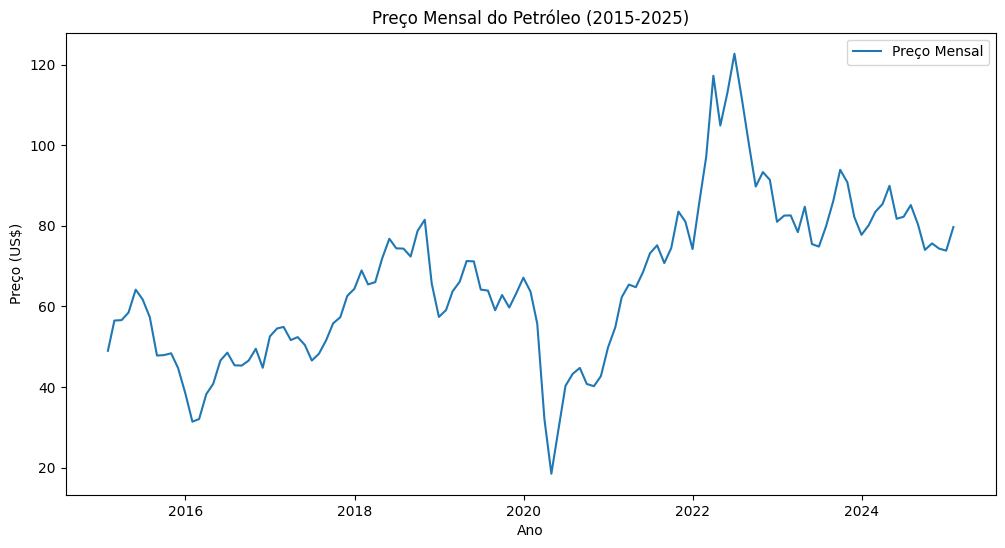

In [39]:
import matplotlib.pyplot as plt

# Visualização da série temporal
plt.figure(figsize=(12, 6))
plt.plot(df_monthly, label='Preço Mensal')
plt.title('Preço Mensal do Petróleo (2015-2025)')
plt.xlabel('Ano')
plt.ylabel('Preço (R$)')
plt.legend()
plt.show()

#### Análise de estatísticas descritivas: fornecem uma visão geral da distribuição dos dados, ajudando a identificar possíveis assimetrias ou outliers.

In [31]:
df.describe()

,preco
count,2961.000000
mean,64.541033
std,19.132347
min,9.120000
25%,49.390000
50%,63.450000
75%,77.110000
max,133.180000


#### Decomposição da série temporal: separar a série em componentes ajuda a entender melhor as influências individuais de tendência e sazonalidade.

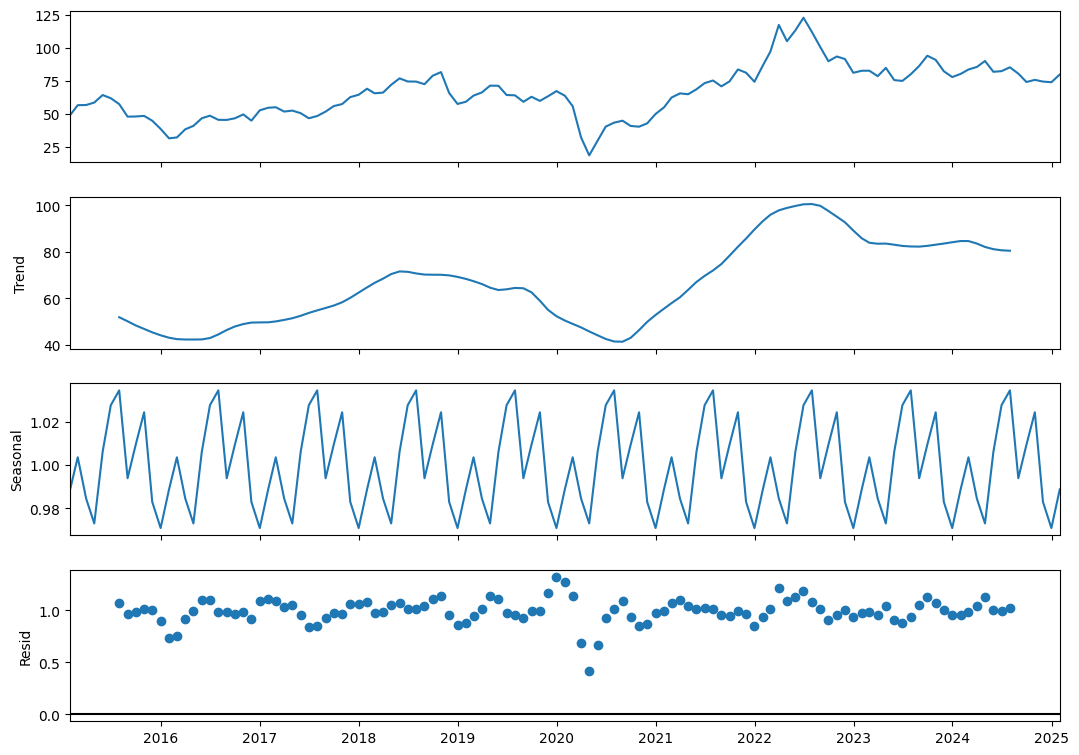

In [40]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df_monthly, model='multiplicative')
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()

#### Análise de Autocorrelação: as funções ACF e PACF ajudam a identificar a dependência temporal nos dados, essencial para a escolha de modelos de séries temporais.

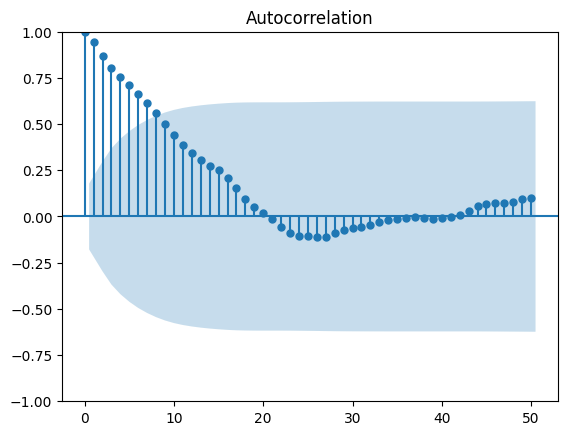

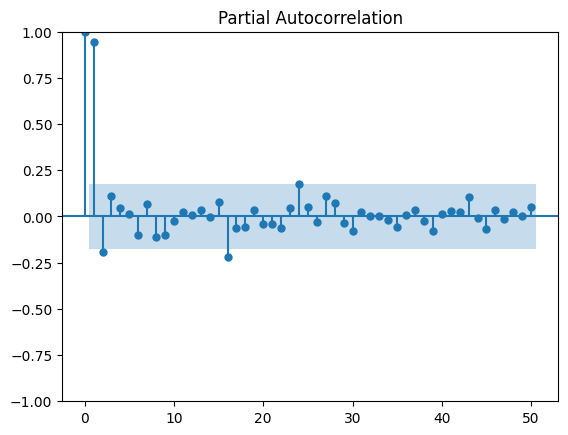

In [43]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Análise de autocorrelação
plot_acf(df_monthly, lags=50)
plt.show()

plot_pacf(df_monthly, lags=50)
plt.show()


### Feature Engineering

#### Médias móveis: eliminam ruído e ajudam a identificar tendências sem depender apenas dos valores brutos.

In [16]:
df['SMA_3'] = df['preco'].rolling(window=3).mean()
df['SMA_6'] = df['preco'].rolling(window=6).mean()  
df['SMA_12'] = df['preco'].rolling(window=12).mean() 

#### Variação percentual: calculo da variação percentual do preço do petróleo em relação ao mês anterior, ajudando a identificar mudanças abruptas, capturando momentos de alta volatilidade.

In [17]:
df['pct_change'] = df['preco'].pct_change()

#### Preço desafado (lag features): mantêm informações do passado (1, 3 e 6 meses anteriores), fundamentais para previsões de séries temporais.

In [19]:
df['lag_1'] = df['preco'].shift(1)
df['lag_3'] = df['preco'].shift(3)
df['lag_6'] = df['preco'].shift(6)

In [20]:
# Removendo valores nulos criados pelas transformações
df.dropna(inplace=True)

df

,preco,SMA_3,SMA_6,SMA_12,pct_change,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag_1,lag_3,lag_6
data,,,,,,,,,,,,,,,,,,,
2015-12-31,38.506774,43.858513,47.430048,52.581900,-0.138776,False,False,False,False,False,False,False,False,False,False,True,44.711667,47.907333,61.733333
2016-01-31,31.384194,38.200878,43.110532,51.116093,-0.184970,False,False,False,False,False,False,False,False,False,False,False,38.506774,48.357097,57.301290
2016-02-29,32.038621,33.976529,40.484281,49.079192,0.020852,True,False,False,False,False,False,False,False,False,False,False,31.384194,44.711667,47.796129
2016-03-31,38.218387,33.880400,38.869456,47.548386,0.192885,False,True,False,False,False,False,False,False,False,False,False,32.038621,38.506774,47.907333
2016-04-30,40.789667,37.015558,37.608218,46.075025,0.067279,False,False,True,False,False,False,False,False,False,False,False,38.218387,31.384194,48.357097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-30,74.016667,79.841649,82.242539,82.764211,-0.078882,False,False,False,False,False,False,False,True,False,False,False,80.355238,82.246000,85.408500
2024-10-31,75.632609,76.668171,79.858291,81.502285,0.021832,False,False,False,False,False,False,False,False,True,False,False,74.016667,85.153043,89.938095
2024-11-30,74.345238,74.664838,78.624799,80.850397,-0.017021,False,False,False,False,False,False,False,False,False,True,False,75.632609,80.355238,81.746190


### Machine Learning

#### Análise do Melhor Modelo

Para identificar o melhor modelo para a previsão de séries temporais, testamos três abordagens distintas:

LSTM (Long Short-Term Memory): Escolhemos o LSTM devido à sua capacidade de capturar dependências temporais de longo prazo e sequenciais, o que é essencial para lidar com dados de séries temporais, onde o padrão ao longo do tempo é crucial para a precisão das previsões.

Gradient Boosting: Este modelo foi testado pela sua robustez e pela habilidade de modelar padrões não lineares e interações complexas em dados tabulares. Sua capacidade de melhorar o desempenho de modelos fracos, combinando várias árvores de decisão, o torna uma excelente opção quando lidamos com múltiplas variáveis e dados heterogêneos.

XGBoost: Optamos também pelo XGBoost, conhecido por sua otimização e alta performance, especialmente quando lidamos com grandes volumes de dados. Além disso, sua capacidade de generalizar bem, mesmo com ajustes finos de parâmetros, é uma característica essencial para garantir precisão e evitar overfitting.

Além disso, implementamos um método para verificar a correlação entre as features. Caso alguma delas apresente uma correlação superior a 90%, removemos essas variáveis para evitar o risco de overfitting, garantindo que o modelo mantenha sua generalização.

Por fim, comparamos os resultados dos três modelos e salvamos aquele que apresentou o melhor desempenho, garantindo assim a escolha da abordagem mais eficaz para nosso problema de previsão.

In [71]:
from datetime import datetime
import os
import pandas as pd
import numpy as np
import logging
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense # type: ignore
from sklearn.preprocessing import MinMaxScaler
import joblib
import warnings
warnings.filterwarnings("ignore")

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', force=True)

def load_and_preprocess_data(url, cutoff_date):
    try:
        tables = pd.read_html(url, decimal=',', thousands='.')
        df = tables[2].drop(index=0).reset_index(drop=True)
        df.columns = ['date', 'price']
        df['date'] = pd.to_datetime(df['date'], dayfirst=True, errors='coerce')
        df['price'] = pd.to_numeric(df['price'], errors='coerce')
        df.sort_values(by='date', inplace=True)
        df.set_index('date', inplace=True)
        df = df[df.index > cutoff_date].dropna(subset=['price']).reset_index()
        df = create_features(df)
        df = remove_high_correlation(df)
        logging.info(f"Data loaded with {df.shape[0]} records and {df.shape[1]} features.")
        return df
    except Exception as e:
        logging.error(f"Error loading data: {e}")
        return None

def create_features(df):
    df['SMA_3'] = df['price'].rolling(window=3).mean()
    df['SMA_6'] = df['price'].rolling(window=6).mean()  
    df['SMA_12'] = df['price'].rolling(window=12).mean() 
    df['pct_change'] = df['price'].pct_change()
    df['lag_1'] = df['price'].shift(1)
    df['lag_3'] = df['price'].shift(3)
    df['lag_6'] = df['price'].shift(6)
    df.dropna(inplace=True)
    return df

def remove_high_correlation(df, threshold=0.9):
    correlation_matrix = df.corr()
    upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
    drop_cols = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
    df = df.drop(columns=drop_cols)
    logging.info(f"Removed {len(drop_cols)} highly correlated features: {drop_cols}")
    return df

def scale_data(df):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df.drop(columns=['date']))
    return scaled_data, scaler

def prepare_ml_data(df, sequence_length):
    scaled_data, scaler = scale_data(df)
    X, y = [], []
    for i in range(len(scaled_data) - sequence_length):
        X.append(scaled_data[i:i+sequence_length])
        y.append(scaled_data[i + sequence_length][0])
    return np.array(X), np.array(y), scaler

class BaseModel:
    def train(self):
        pass
    
    def predict(self):
        pass
    
    def evaluate(self, y_test, predictions):
        return {
            "r2": r2_score(y_test, predictions),
            "mse": mean_squared_error(y_test, predictions),
            "mae": mean_absolute_error(y_test, predictions),
            "rmse": np.sqrt(mean_squared_error(y_test, predictions))
        }

class LSTMModel(BaseModel):
    def __init__(self, sequence_length, feature_size):
        self.sequence_length = sequence_length
        self.feature_size = feature_size
        self.model = Sequential([ 
            LSTM(50, input_shape=(sequence_length, feature_size)),
            Dense(1)
        ])
        self.model.compile(optimizer='adam', loss='mean_squared_error')
    
    def train(self, X_train, y_train, epochs=100, batch_size=32):
        self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
    
    def predict(self, X_test):
        return self.model.predict(X_test).flatten()

class GradientBoostingModel(BaseModel):
    def __init__(self):
        self.model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05)
    
    def train(self, X_train, y_train):
        self.model.fit(X_train.reshape(X_train.shape[0], -1), y_train)
    
    def predict(self, X_test):
        return self.model.predict(X_test.reshape(X_test.shape[0], -1))

class XGBoostModel(BaseModel):
    def __init__(self):
        self.model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, learning_rate=0.05)
    
    def train(self, X_train, y_train):
        self.model.fit(X_train.reshape(X_train.shape[0], -1), y_train)
    
    def predict(self, X_test):
        return self.model.predict(X_test.reshape(X_test.shape[0], -1))

def run_pipeline(models, df, sequence_length=10):
    X, y, scaler = prepare_ml_data(df, sequence_length)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    best_model, best_score = None, -np.inf
    for model in models:
        logging.info(f"Training {model.__class__.__name__}...")
        model.train(X_train, y_train)
        predictions = model.predict(X_test)
        metrics = model.evaluate(y_test, predictions)
        logging.info(f"{model.__class__.__name__} - R²: {metrics['r2']:.4f}, RMSE: {metrics['rmse']:.4f}")
        if metrics['r2'] > best_score:
            best_score, best_model = metrics['r2'], model
    return best_model, scaler

def save_model(model, model_name, models_dir):
    if isinstance(model, LSTMModel):
        model.model.save(os.path.join(models_dir, f"{model_name}.keras"))
    else:
        joblib.dump(model.model, os.path.join(models_dir, f"{model_name}.joblib"))

def main():
    url = 'http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view'    
    startDate = f"{datetime.today().year - 10}-{datetime.today().month }-{datetime.today().day}"
    df = load_and_preprocess_data(url, startDate)
    if df is None:
        return
    feature_size = df.shape[1] - 1
    models = [
        LSTMModel(sequence_length=10, feature_size=feature_size),
        GradientBoostingModel(),
        XGBoostModel()
    ]   

    best_model, scaler = run_pipeline(models, df)
    if best_model:
        model_name = best_model.__class__.__name__
        models_dir = os.path.join(os.path.abspath(os.path.pardir), 'models')        
        os.makedirs(models_dir, exist_ok=True)        
        save_model(best_model, model_name, models_dir)        
        joblib.dump(scaler, os.path.join(models_dir, "scaler.joblib"))        
        logging.info(f"Saved best model: {model_name}")

if __name__ == "__main__":
    main()


2025-02-05 11:36:38,695 - INFO - Removed 6 highly correlated features: ['SMA_3', 'SMA_6', 'SMA_12', 'lag_1', 'lag_3', 'lag_6']
2025-02-05 11:36:38,697 - INFO - Data loaded with 2949 records and 3 features.
2025-02-05 11:36:38,744 - INFO - Training LSTMModel...


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2025-02-05 11:37:24,643 - INFO - LSTMModel - R²: 0.9258, RMSE: 0.0137
2025-02-05 11:37:24,644 - INFO - Training GradientBoostingModel...
2025-02-05 11:37:28,360 - INFO - GradientBoostingModel - R²: 0.9253, RMSE: 0.0138
2025-02-05 11:37:28,361 - INFO - Training XGBoostModel...
2025-02-05 11:37:28,841 - INFO - XGBoostModel - R²: 0.9003, RMSE: 0.0159
2025-02-05 11:37:28,884 - INFO - Saved best model: LSTMModel
